In [74]:
import os
import json
import wandb
import random
import argparse
import itertools
import numpy as np
from time import gmtime, strftime

import soundfile as sf

import torch
import torchaudio
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import PIL

import sys
sys.path.append('../training')
sys.path.append('../training/networks/nansypp')
sys.path.append('../testing')
from hifigan.generator import HifiganGenerator
from hifigan.vctk_loader import VCTK_dataset, LogMelSpectrogram

from datasets.loader import Dataset
from networks.discriminator import Discriminator
# from networks.f2v import F2V_Ecapa
from nansypp import Nansypp
from hyface import Nansy, BShall_Nimbre, BShall_Ecapa
# import loss_funcs

from utils import audio_utils
from utils.data_utils import phoneme_inventory, decollate_tensor, combine_fixed_length
from utils import utils

import IPython.display as ipd

In [77]:
from typing import Dict, Tuple
from utils import data_utils, utils, audio_utils
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
%matplotlib inline

# Face2Voice

In [46]:
class FaceNAudio_Spkwise(torch.utils.data.Dataset):
    def __init__(self,
                args,
                meta_root = 'filelists/VGG_Face',
                mode='train',
                img_datasets=['VGG_Face_Spk'],
                sample_rate = 16000, 
                ):
        self.args = args
        self.mode = mode
        self.img_datasets = img_datasets
        self.sample_rate = sample_rate
        self.max_sec = 4
        self.max_len = sample_rate * self.max_sec
        self.data_files = []
        for dset in img_datasets:
            meta_file_path = os.path.join(meta_root, '{}_{}.txt').format(dset, mode)
            files = data_utils.load_text(meta_file_path)
            self.data_files += files
        self.data_files_len = len(self.data_files)
        self.trans = transforms.Compose([transforms.Resize((args.features.image.size,args.features.image.size), interpolation=PIL.Image.BICUBIC),
                transforms.CenterCrop(args.features.image.size), transforms.ToTensor(),
                # transforms.Normalize(mean=[0.4850, 0.4560, 0.4060], std=[0.2290, 0.2240, 0.2250])])
                transforms.Normalize(mean=[0.4829, 0.4049, 0.3712], std=[0.2643, 0.2398, 0.2335])])

    def __getitem__(self, index):
        spkr = self.data_files[index % self.data_files_len]
        
        # image load
        img_names = os.listdir(os.path.join(self.args.data.img_datadir, spkr))
        random_img_name = random.choice(img_names)
        img_path = os.path.join(self.args.data.img_datadir, spkr, random_img_name)
        img = Image.open(img_path)
        img_tensor = self.trans(img)

        # audio load
        aud_names = os.listdir(os.path.join(self.args.data.aud_datadir, spkr))
        random_aud_name = random.choice(aud_names)
        aud_path = os.path.join(self.args.data.aud_datadir, spkr, random_aud_name)
        aud = audio_utils.load_wav(path=aud_path, sr=self.args.data.sample_rate,
                                   max_len=self.max_len, pos='random')
        aud_pad = np.pad(aud[:self.max_len], [0, self.max_len - len(aud)])
        return img_tensor, aud_pad

    def __len__(self):
        return len(self.data_files)*self.args.data.img_nums

class FaceNEcapaAVg_Filewise(torch.utils.data.Dataset):
    def __init__(self,
                args,
                meta_root = 'filelists/VGG_Face',
                mode='train',
                img_datasets=['VGG_Face'],
                ):
        self.args = args
        self.mode = mode
        self.img_datasets = img_datasets
        self.data_files = []
        for dset in img_datasets:
            meta_file_path = os.path.join(meta_root, '{}_{}.txt').format(dset, mode)
            files = data_utils.load_text(meta_file_path)
            self.data_files += files
        self.data_files_len = len(self.data_files)
        self.trans = transforms.Compose([transforms.Resize((args.features.image.size,args.features.image.size), interpolation=PIL.Image.BICUBIC),
                transforms.CenterCrop(args.features.image.size), transforms.ToTensor(),
                # transforms.Normalize(mean=[0.4850, 0.4560, 0.4060], std=[0.2290, 0.2240, 0.2250])])
                transforms.Normalize(mean=[0.4829, 0.4049, 0.3712], std=[0.2643, 0.2398, 0.2335])])

    def path_to_spk(self, path):
        return os.path.basename(os.path.dirname(path))
                                
    def __getitem__(self, index):
        # image load
        img_path = self.data_files[index]
        img = Image.open(img_path)
        img_tensor = self.trans(img)

        # audio load
        spk = self.path_to_spk(img_path)
        ecapa_avg = np.load(os.path.join(self.args.data.aud_datadir, spk + '.npy'))
        
        return img_tensor, torch.tensor(ecapa_avg)

    def __len__(self):
        return len(self.data_files)


class Faubert_Dataset(torch.utils.data.Dataset):
    def __init__(self,
                args,
                meta_root = 'filelists',
                mode='train',
                datasets=['VGG_Face'],
                sample_rate = 16000, 
                ):
        self.args = args
        self.mode = mode
        self.datasets = datasets
        self.sample_rate = sample_rate
        self.max_sec = 4
        self.max_len = sample_rate * self.max_sec
        self.data_files = []
        for dset in datasets:
            meta_file_path = os.path.join(meta_root, '{}_{}.txt').format(dset, mode)
            files = data_utils.load_text(meta_file_path)
            self.data_files += files
        self.trans = transforms.Compose([transforms.Resize((args.features.image.size,args.features.image.size), interpolation=PIL.Image.BICUBIC),
                transforms.CenterCrop(args.features.image.size), transforms.ToTensor(),
                transforms.Normalize(mean=[0.4829, 0.4049, 0.3712], std=[0.2643, 0.2398, 0.2335])])

    def __getitem__(self, index):
        # image load
        img_path = self.data_files[index]
        img = Image.open(img_path)
        img_tensor = self.trans(img)
        
        # audio load
        aud_folder = os.path.dirname(img_path).replace('VGG_Face2/data','VoxCeleb2/VoxCeleb2')
        aud_names = os.listdir(aud_folder)
        random_aud_name = random.choice(aud_names)
        aud_path = os.path.join(aud_folder, random_aud_name)
        aud, pos = audio_utils.load_wav(path=aud_path, max_len=self.max_len, pos='random')
        
        # hubert load
        hubert_pos = int(pos / 320)
        hubert_path = aud_path.replace('original', 'modified/hubert_soft').replace('.wav', '.emb')
        hubert_emb = torch.load(hubert_path).squeeze(0)[hubert_pos:hubert_pos+self.max_sec*50]
        return img_tensor, aud, hubert_emb

    def collate(self, bunch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
        """Collate bunch of datum to the batch data.
        Args:
            bunch: B x [np.float32; [T]], speech signal.
        Returns:
            batch data.
                speeches: [np.float32; [B, T]], speech signal.
                lengths: [np.long; [B]], speech lengths.
        """
        img_pad = torch.stack([img_tensor for img_tensor, _, _ in bunch])
        # [B]
        frame_lengths = np.array([hubert_emb.shape[0]*2 for _, _, hubert_emb in bunch])
        # []
        max_framelen = frame_lengths.max()
        # [B, T]
        aud_pad = np.stack([
            np.pad(aud[:frame_lengths[i]*160], [0, max_framelen*160 - frame_lengths[i]*160]) for i, (img, aud, _) in enumerate(bunch)])
        hubert_pad = pad_sequence([hubert_emb for _, _, hubert_emb in bunch]).transpose(0,1)
        data = {'img':img_pad, 'aud':aud_pad, 'hubert':hubert_pad.transpose(-1,-2), 'frame_lengths':frame_lengths}
        return data

    def __len__(self):
        return len(self.data_files)

In [271]:
# main_dir = '/home/jaejun/nansy/
config_path = '../training/configs/f2v_audio.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

trainset = FaceNAudio_Spkwise(args, img_datasets=args.data.img_datasets, meta_root='../training/filelists/VGG_Face')
train_loader = DataLoader(trainset, batch_size=4, shuffle=True)

In [272]:
# main_dir = '/home/jaejun/nansy/
config_path = '../training/configs/f2v_ecapa.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

trainset2 = FaceNEcapaAVg_Filewise(args, img_datasets=args.data.img_datasets, meta_root='../training/filelists/VGG_Face')
train_loader2 = DataLoader(trainset2, batch_size=4, shuffle=True)

In [282]:
print(trainset[0][0].shape, trainset[0][1].shape)
img, aud = next(iter(train_loader))
print(img.shape, aud.shape)

torch.Size([3, 224, 224]) (64000,)
torch.Size([4, 3, 224, 224]) torch.Size([4, 64000])


In [278]:
print(trainset2[0][0].shape, trainset2[0][1].shape)
img, aud = next(iter(train_loader2))
print(img.shape, aud.shape)

torch.Size([3, 224, 224]) torch.Size([1, 192])
torch.Size([4, 3, 224, 224]) torch.Size([4, 1, 192])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


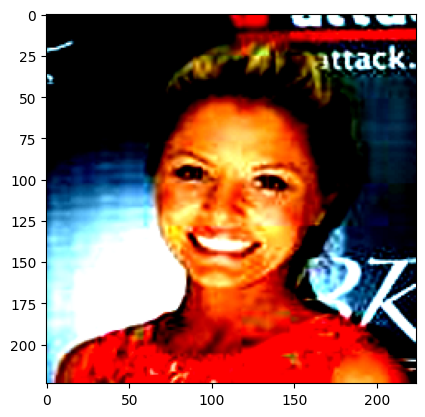

In [283]:
plt.imshow(img[0].permute(1,2,0))

In [284]:
ipd.Audio(aud[0], rate=16000)

## Faubert_Dataset test

In [78]:
# main_dir = '/home/jaejun/nansy/
config_path = '../training/configs/face_nimbre.json'
with open(config_path, "r") as f:
    data = f.read()
config = json.loads(data)
args = utils.HParams(**config)

trainset = Faubert_Dataset(args, datasets=args.data.img_datasets, meta_root='../training/filelists/VGG_Face')
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, collate_fn=trainset.collate)

In [123]:
data = next(iter(train_loader))
data['img'].shape, data['aud'].shape, data['hubert'].shape, data['frame_lengths']

(torch.Size([4, 3, 224, 224]),
 (4, 64000),
 torch.Size([4, 256, 200]),
 array([400, 400, 400, 400]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


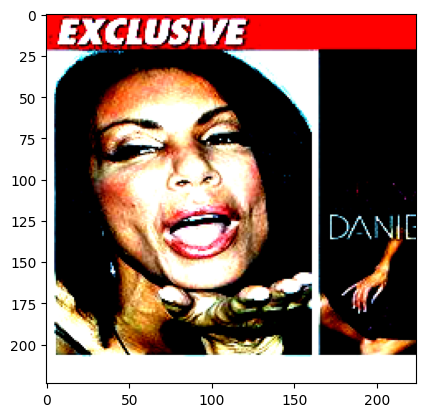

In [124]:
plt.imshow(data['img'][0].permute(1,2,0))
plt.show()
ipd.Audio(data['aud'][0], rate=16000)